# Part 3

## loading the packages

In [32]:
import numpy as np

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from tqdm import tqdm


import folium 

print('Libraries imported.')

Libraries imported.


## loading the data from the previous part

In [11]:
df = pd.read_csv("Toronto_with_cordinates.csv")

df.shape

(45, 6)

In [96]:


def getNearbyVenues(names, latitudes, longitudes, radius=500):

    VERSION = '20180605'
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
Toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Ontario Provincial Government
Islington Avenue
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Markland Wood
Caledonia-Fairbanks
Woburn
Leaside
Bay Street
Cedarbrae
Hillcrest Village
Thorncliffe Park
Dovercourt Village
Scarborough Village
Henry Farm
The Danforth
Trinity
Bayview Village
Riverdale
York Mills
Downsview
The Beaches
Maple Leaf Park
Humber Summit
Newtonbrook
Downsview
Willowdale
Downsview
Weston
York Mills
The Junction
Willowdale
Roncesvalles
Kingsview Village
Agincourt
University of Toronto
Swansea
Summerhill
Rosedale
Upper Rouge
Church and Wellesley


In [83]:
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()


In [84]:
inertia =[]

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
for i in range (1,10):
    # run k-means clustering
    kmeans = KMeans(n_clusters=i, random_state=0).fit(Toronto_grouped_clustering)
    inertia.append(kmeans.inertia_)

    

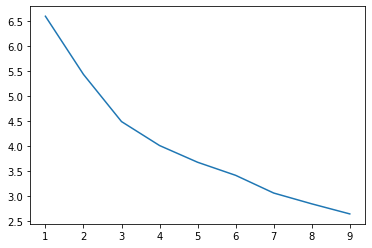

In [85]:

sns.lineplot(x =list(range (1,10)), y=inertia);

In [86]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(Toronto_grouped_clustering)

In [87]:
#Toronto_grouped.drop(columns='Cluster Labels',inplace=True)

In [88]:
Toronto_grouped.insert(0, 'Cluster Labels',kmeans.labels_)

In [91]:
Toronto_grouped = (Toronto_grouped
                   .set_index("Neighborhood")
                   .join(Toronto_venues[["Neighborhood","Neighborhood Latitude","Neighborhood Longitude"]]
                         .set_index("Neighborhood").drop_duplicates()
                 ))

In [93]:
Toronto_grouped.reset_index(inplace = True)

In [94]:
# create map
latitude  = 43.794200
longitude = -79.262029
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_grouped['Neighborhood Latitude'], Toronto_grouped['Neighborhood Longitude'], Toronto_grouped['Neighborhood'], Toronto_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters